In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn import Linear, Softmax, Sigmoid, Module
from scipy.optimize import minimize
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.connectors import TorchConnector
import qiskit
import qiskit_machine_learning
print(qiskit.version.get_version_info())
print(qiskit_machine_learning.version.get_version_info())

1.2.4
0.8.0


In [2]:
# Creating Circuit

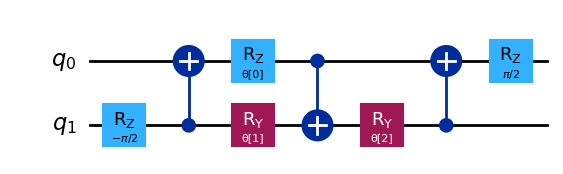

In [3]:
# Two qubit unitary as defined
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

# Visual
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl")

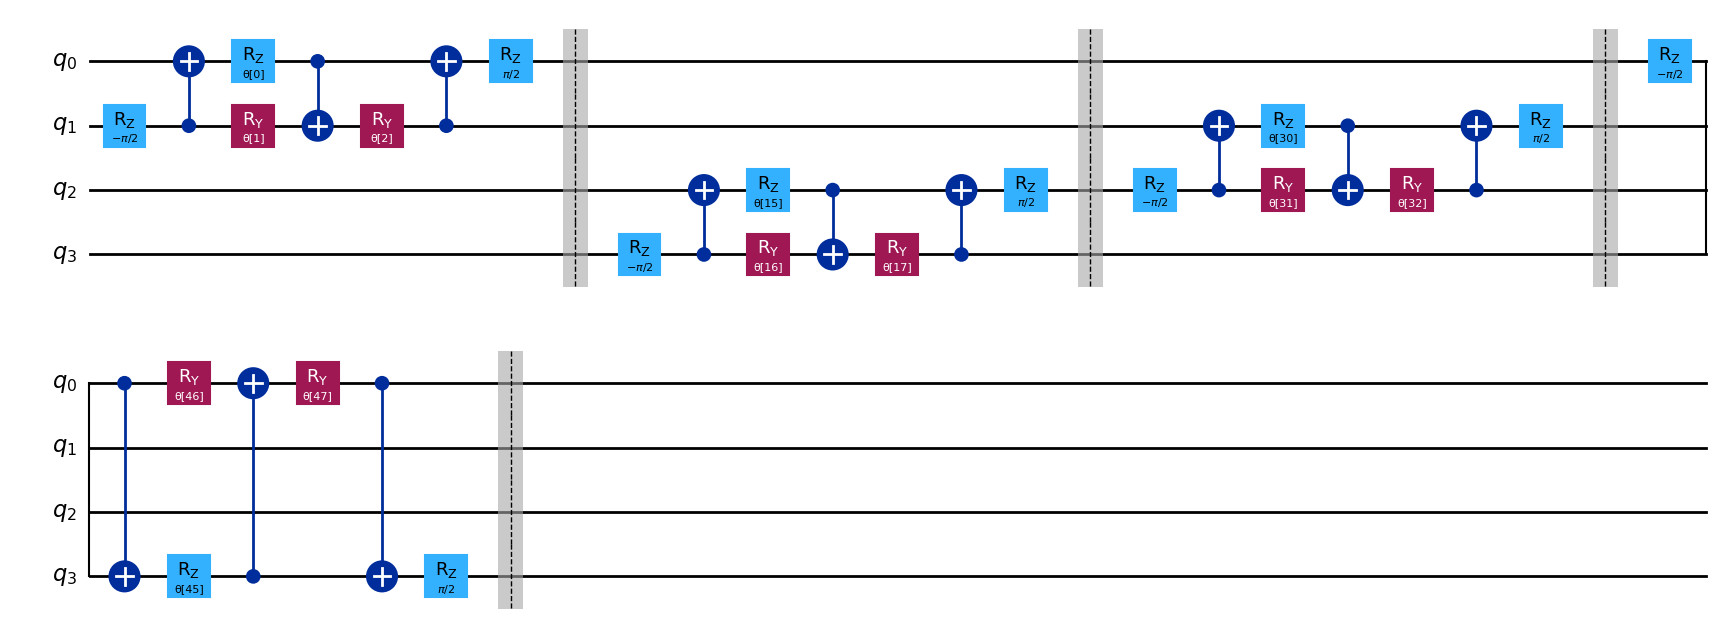

In [4]:
# Create Layer (Repeating Circuit on Neighboring Qubits).
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 15)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 15)]), [q1, q2])
        qc.barrier()
        param_index += 15
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 15)]), [q1, q2])
        qc.barrier()
        param_index += 15

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

# Visual
circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl")

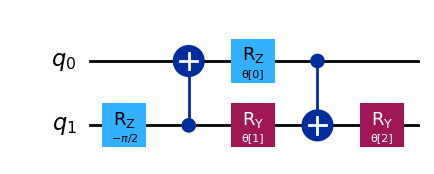

In [5]:
# Defining Pool Circuit
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target

# Visual
params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl")

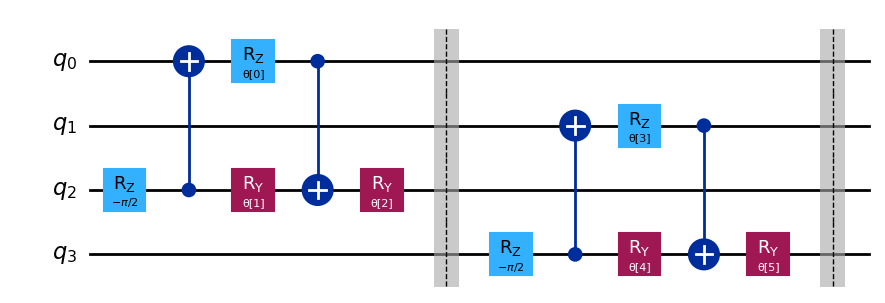

In [6]:
# Defining Pool Layer (Repeating Circuit on Neighboring Qubits)
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

# Visual
sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl")

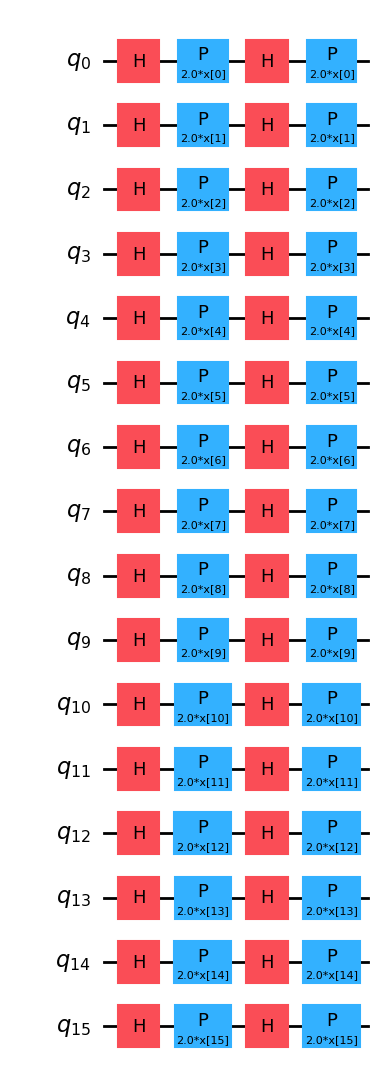

In [7]:
# Feature Map Instantiation
feature_map = ZFeatureMap(16)
feature_map.decompose().draw("mpl")

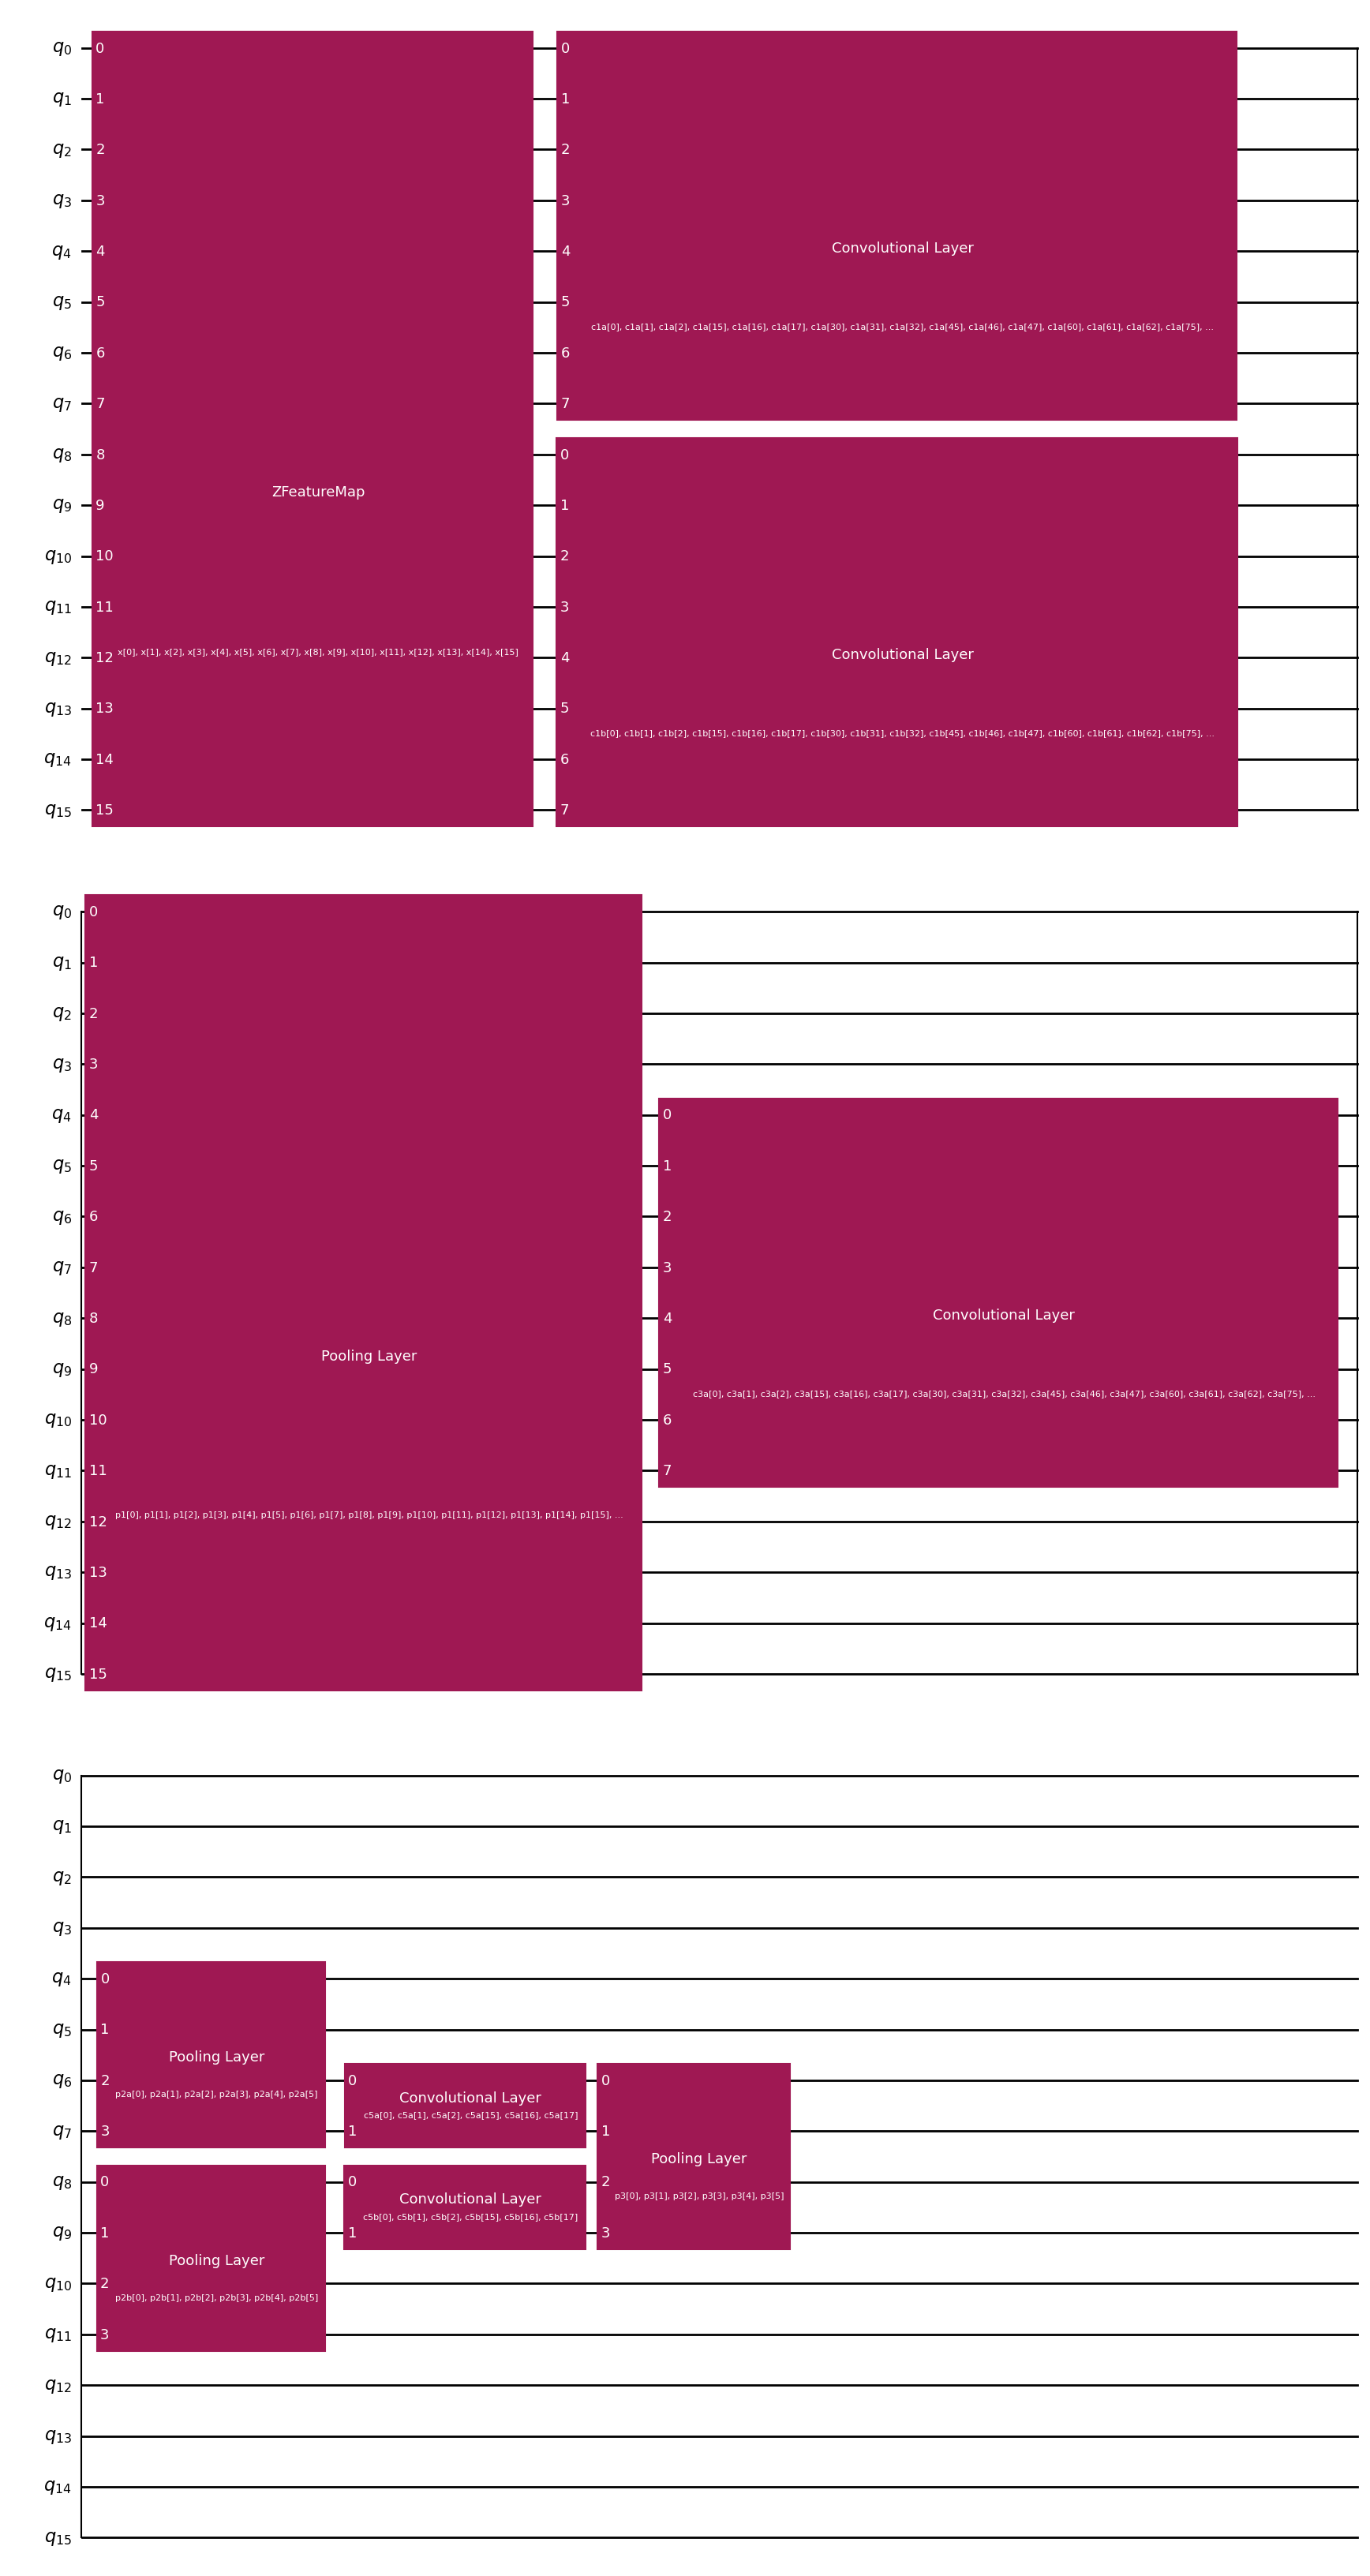

In [8]:
# Ansatz Instantiation Method
from qiskit import ClassicalRegister, QuantumRegister
def create_QCNN():
    q_reg = QuantumRegister(16, "q_reg")
    ansatz = QuantumCircuit(q_reg, name="Ansatz")

    # First Convolutional Layer Set
    ansatz.compose(conv_layer(8, "с1a"), list(range(8)), inplace=True)
    ansatz.compose(conv_layer(8, "с1b"), list(range(8,16)), inplace=True)
    
    # First Pooling Layer Set
    ansatz.compose(pool_layer([0, 1, 2, 3, 12, 13, 14, 15], [4, 5, 6, 7, 8, 9, 10, 11], "p1"), list(range(16)), inplace=True)

    # Third Convolutional Layer Set
    ansatz.compose(conv_layer(8, "с3a"), list(range(4,12)), inplace=True)

    # Second Pooling Layer Set
    ansatz.compose(pool_layer([0, 1], [2, 3], "p2a"), list(range(4,8)), inplace=True)
    ansatz.compose(pool_layer([2, 3], [0, 1], "p2b"), list(range(8,12)), inplace=True)

    # Fifth Convolutional Layer Set
    ansatz.compose(conv_layer(2, "с5a"), list(range(6,8)), inplace=True)
    ansatz.compose(conv_layer(2, "с5b"), list(range(8,10)), inplace=True)

    # Third Pooling Layer Set
    ansatz.compose(pool_layer([0,1], [2,3], "p3"), list(range(6,10)), inplace=True)

    # Combining the feature map and ansatz
    circuit = QNNCircuit(16)
    circuit.feature_map = feature_map
    circuit.ansatz = ansatz
    return circuit

# Visual
display(create_QCNN().draw("mpl"))

In [9]:
# Creating/Formatting Data

In [10]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train[..., np.newaxis]/(255.0/np.pi), x_test[..., np.newaxis]/(255.0/np.pi)
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

2024-12-09 20:00:44.283102: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733803244.295158   53908 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733803244.298707   53908 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 20:00:44.310524: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Number of original training examples: 60000
Number of original test examples: 10000


In [11]:
# Filter Values
a = 3
b = 4
def filter_abcd(x, y):
    keep = (y == a) | (y == b)
    x, y = x[keep], y[keep]
    return x,y

In [12]:
# Filtering using previous method.
x_train, y_train = filter_abcd(x_train, y_train)
x_test, y_test = filter_abcd(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 11973
Number of filtered test examples: 1992


4


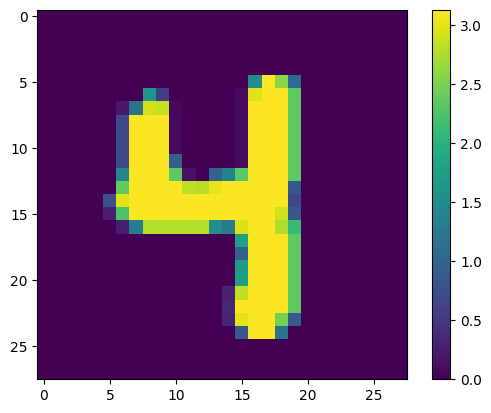

In [13]:
# Displaying Sample Image
img = 13
print(y_train[img])
plt.imshow(x_train[img, :, :, 0])
plt.colorbar()

In [14]:
# Resizing (Quantum Computing Simulation Limit)
x_train_small = tf.image.resize(x_train, (4,4), method = 'area').numpy()
x_test_small = tf.image.resize(x_test, (4,4), method = 'area').numpy()

I0000 00:00:1733803246.293425   53908 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21458 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


4


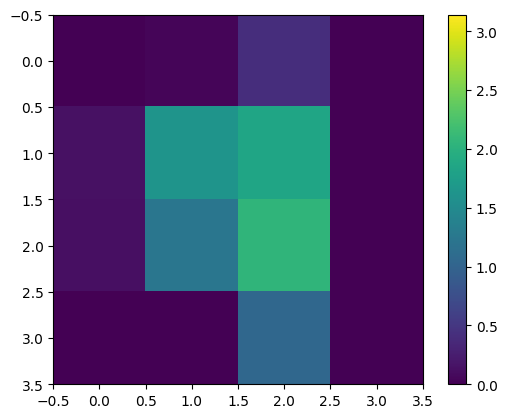

In [15]:
# Displaying Image Sample After Resizing
img = 13
print(y_train[img])
plt.imshow(x_train_small[img,:,:,0], vmin=0, vmax=np.pi)
plt.colorbar()

In [16]:
# Formatting Helper Methods
def format_data(a,b):
    x_reshaped = []
    x1_reshaped = []

    for g in a:
        x_reshaped.append(g.reshape(1,16))

    for g in b:
        x1_reshaped.append(g.reshape(1,16))

    final_x = []
    final_x1 = []

    for entry in x_reshaped:
        final_x.append(entry[0])

    for entry in x1_reshaped:
        final_x1.append(entry[0])
    return final_x, final_x1

def format_labels(y):
    y_temp = []
    for entry in y:
        if entry == a:
            y_temp.append(0)
        elif entry == b:
            y_temp.append(1)
    return y_temp

In [17]:
x,x1 = format_data(x_train_small, x_test_small)

# Easier to work with names
y = y_train
y1 = y_test

# Setting labels to 0,1,2,3 for easy reference later
y = format_labels(y)
y1 = format_labels(y1)

# Converting to nparray
x = np.asarray(x)
y = np.asarray(y)
x1 = np.asarray(x1)
y1 = np.asarray(y1)

# Limiting training dataset to lower training time.
x = x[0:128]
y = y[0:128]
x1 = x1[0:128]
y1 = y1[0:128]
print(x)
print(y)

[[0.0359542  0.         0.04701703 ... 0.         0.54685587 0.        ]
 [0.         0.26902792 0.86968946 ... 1.3765682  0.4684103  0.        ]
 [0.         0.         0.0341942  ... 0.43195325 0.         0.        ]
 ...
 [0.         0.         0.         ... 0.24765654 0.         0.        ]
 [0.         0.00176    0.00226285 ... 0.45030752 0.         0.        ]
 [0.         0.03494849 0.70274127 ... 0.9101693  0.01055997 0.        ]]
[1 0 1 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0 1 1 0 0 0 1 1 0 1 0 0 1 1 0 1 0 1 1
 1 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 0
 1 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 1 1 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0
 1 1 0 1 0 1 1 1 1 0 1 0 0 0 1 1 0]


In [18]:
# Additional Helper Functions
def count(y):
    counta = 0
    countb = 0
    for i in range(len(y)):
        if y[i] == 0:
            counta+=1
        elif y[i] == 1:
            countb+=1
    return(counta, countb)

def balance_lists(x, y, max_count):
    """Balances two lists x and y based on the values in y (0 or 1)."""
    
    x_balanced = []
    y_balanced = []
    count0 = 0
    count1 = 0

    for i in range(len(y)):
        if y[i] == 0:
            if count0 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count0 += 1
        elif y[i] == 1:
            if count1 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count1 += 1
    return x_balanced, y_balanced

def shuffle(arr1, arr2):
    assert len(arr1) == len(arr2)
    p = np.random.permutation(len(arr1))
    return arr1[p], arr2[p]

In [19]:
# Further Data Cleaning Using Helper Functions
nums = count(y)
print("original:", nums)
max_count = min(nums)
print("max_count =", max_count)
x,y = balance_lists(x, y, max_count)

print("balanced:", count(y))

# Converting to nparray
x = np.asarray(x)
y = np.asarray(y)
x1 = np.asarray(x1)
y1 = np.asarray(y1)
objective_func_vals = []

x,y = shuffle(x,y)
print("shuffled:", count(y))

print("final:", x)
print(y)

original: (64, 64)
max_count = 64
balanced: (64, 64)
shuffled: (64, 64)
final: [[0.         0.         0.26525652 ... 0.10182833 0.33993062 0.        ]
 [0.         0.05204559 0.5790386  ... 0.7721354  0.23307374 0.        ]
 [0.         0.00276571 0.03042278 ... 0.74824965 0.         0.        ]
 ...
 [0.         0.06863984 0.1141483  ... 0.9991748  0.16041104 0.        ]
 [0.         0.         0.32861638 ... 0.02941707 0.4832446  0.        ]
 [0.         0.         0.         ... 0.1267197  0.         0.        ]]
[1 0 1 0 0 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 1 0 1 1 1 0 0 0 1 1 1 0 0 1 0 0 1
 1 0 1 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1 1 0 0 1 1 1 0 0 1 1 0 1 0 1 0 0 0
 1 0 0 0 1 0 0 1 1 0 1 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 1 0 1 0 1 1 1 0 1 0 1
 1 1 0 0 0 1 0 0 1 1 0 1 1 1 0 1 1]


In [20]:
# Tensor for Pytorch
X = torch.tensor(x, dtype=torch.float32).to("cuda")
Y = torch.tensor(y, dtype=torch.long).to("cuda")
X1 = torch.tensor(x1, dtype=torch.float32).to("cuda")
Y1 = torch.tensor(y1, dtype=torch.long).to("cuda")

In [21]:
# One-Hot Encoding for Final Processing
num_classes = 2
Y = (torch.nn.functional.one_hot(Y, num_classes=num_classes).float())
Y1 = (torch.nn.functional.one_hot(Y1, num_classes=num_classes).float())

In [22]:
print(X,Y,X1,Y1)

tensor([[0.0000, 0.0000, 0.2653,  ..., 0.1018, 0.3399, 0.0000],
        [0.0000, 0.0520, 0.5790,  ..., 0.7721, 0.2331, 0.0000],
        [0.0000, 0.0028, 0.0304,  ..., 0.7482, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0686, 0.1141,  ..., 0.9992, 0.1604, 0.0000],
        [0.0000, 0.0000, 0.3286,  ..., 0.0294, 0.4832, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.1267, 0.0000, 0.0000]],
       device='cuda:0') tensor([[0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
  

In [23]:
# Training

In [24]:
# Pytorch Circuit Module
import torch.nn as nn
class Model(Module): # Simplified
    def __init__(self, qnn_module):
        super().__init__()
        self.qnn_module = qnn_module
        self.softmax = nn.Softmax(dim = -1)

    def forward(self, x):
        x = self.qnn_module(x)
        x = self.softmax(x)
        return x

In [25]:
from qiskit_aer.primitives import Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.utils import algorithm_globals

# Reproducable seeds
num_qubits = 16
algorithm_globals.random_seed = 65
seed = 90

# Creating GPU compatible Estimator primitive
sampler = Estimator()
sampler.set_options(device='GPU')
sampler.set_options(method="statevector")
sampler.set_options(seed = seed)

# Setting observables on 15th and 16th qubits.
observable_z10 = SparsePauliOp.from_sparse_list([("Z", [9], 1)], num_qubits=num_qubits)
observable_z9 = SparsePauliOp.from_sparse_list([("Z", [8], 1)], num_qubits=num_qubits)
observables = [observable_z9, observable_z10]

# Instantiating underlying EstimatorQNN
estimator = EstimatorQNN(
    estimator = sampler,
    circuit = create_QCNN(),
    observables = observables,
)

# Initial Forward Weights
weights = algorithm_globals.random.random(estimator.num_weights)

# Checking Data Forward Result
estimator.forward(input_data = x1[:30], weights = weights)

/tmp/ipykernel_53908/979841602.py:22: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  estimator = EstimatorQNN(
/tmp/ipykernel_53908/979841602.py:22: UserWarning: No number of qubits was not specified (None) and was retrieved from `circuit` (16). If `circuit` is transpiled, this may cause unstable behaviour.
  estimator = EstimatorQNN(


array([[-0.07226562, -0.1171875 ],
       [-0.08984375, -0.02929688],
       [-0.08007812, -0.07226562],
       [-0.09179688, -0.0703125 ],
       [-0.06640625, -0.0703125 ],
       [-0.13476562, -0.12109375],
       [-0.1015625 , -0.06445312],
       [-0.09375   , -0.12109375],
       [-0.10546875, -0.078125  ],
       [-0.06445312, -0.10742188],
       [-0.08789062, -0.109375  ],
       [-0.14257812, -0.00585938],
       [-0.08789062, -0.08984375],
       [ 0.01367188, -0.07226562],
       [-0.13867188, -0.13085938],
       [-0.07226562, -0.09179688],
       [-0.07617188, -0.125     ],
       [-0.04101562, -0.04296875],
       [-0.0625    , -0.08203125],
       [-0.07226562, -0.109375  ],
       [-0.16601562, -0.0625    ],
       [-0.10742188, -0.07617188],
       [-0.04296875, -0.1328125 ],
       [-0.14257812, -0.015625  ],
       [-0.10742188, -0.10546875],
       [-0.12109375, -0.12890625],
       [-0.05664062, -0.09375   ],
       [-0.0390625 , -0.04492188],
       [-0.08789062,

In [26]:
# Wrapping estimator with initial weights under TorchConnecter, itself under Pytorch Module.
model = Model(TorchConnector(estimator, weights))
model.to("cuda")
next(model.parameters()).is_cuda

True

In [27]:
model(X[:30])

tensor([[0.5024, 0.4976],
        [0.4839, 0.5161],
        [0.4863, 0.5137],
        [0.4966, 0.5034],
        [0.5049, 0.4951],
        [0.4985, 0.5015],
        [0.4717, 0.5283],
        [0.5015, 0.4985],
        [0.4941, 0.5059],
        [0.5244, 0.4756],
        [0.5122, 0.4878],
        [0.4985, 0.5015],
        [0.4971, 0.5029],
        [0.5185, 0.4815],
        [0.4932, 0.5068],
        [0.5073, 0.4927],
        [0.5107, 0.4893],
        [0.5151, 0.4849],
        [0.5107, 0.4893],
        [0.5107, 0.4893],
        [0.4946, 0.5054],
        [0.4980, 0.5020],
        [0.5117, 0.4883],
        [0.4727, 0.5273],
        [0.4941, 0.5059],
        [0.5122, 0.4878],
        [0.5098, 0.4902],
        [0.5054, 0.4946],
        [0.5083, 0.4917],
        [0.4819, 0.5181]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [28]:
# Callback Helper Functions
loss_func = tf.keras.losses.CategoricalCrossentropy()

def accuracy(output, Y):
    acc = 0
    for i in range(Y.size(dim=0)):
        val = output[i]
        if (torch.argmax(val) == torch.argmax(Y[i])):
            acc+=1
    return ((acc/(Y.size(dim=0)))*100)

def objective_function(weights):
    global X
    global Y
    if(i != 1 and i%333 == 0):
        indices = torch.randperm(X.size()[0])
        X=X[indices]
        Y=Y[indices]
        print(X,Y)
    # Referencing Global Variables
    global data
    # Local Variable
    total_loss = 0.0
    # Overiding with new data
    model = Model(TorchConnector(estimator, weights)).to("cuda")
    # Getting Output
    output = model(X)
    loss_output = output.detach().cpu().numpy()
    loss_Y = Y.detach().cpu().numpy()
    # Calculate Loss
    loss = loss_func(loss_output, loss_Y).numpy()
    # Append Checkpoint Data Points to Tracker
    val = f"Iteration: {i}; Accuracy: {accuracy(output, Y)}%; Loss: {loss}"
    data.append(val)
    total_loss += loss
    loss_list.append(total_loss)
    return total_loss

def callback(weights):
    # Iteration Tracking
    global i
    global weight_list
    # Printing Checkpoint Data Points in Tracker
    print("\n".join(data))
    # Plotting Loss Function
    plt.title("Loss value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Loss function value")
    plt.plot(range(len(loss_list)), loss_list)
    plt.show()
    # Printing Weights
    weight_list.append(weights)
    print(weights)
    # Iteration Counter
    i+=1
    # Clearing Previous Graph/Weights
    clear_output(wait=True)

In [29]:
# Training Function
def fit(weights=None, losslist=None, iter= 1000, fresh_start = False):
    global i
    global data
    global weight_list
    global loss_list
    if(fresh_start):
        loss_list = []
        data = []
        weight_list = []
        weights = algorithm_globals.random.random(estimator.num_weights)
        i = 1
    else:
        if 'data' not in globals(): data = []
        else: data = data
        if 'weight_list' not in globals():weight_list = []
        else: weight_list = weight_list
        if 'i' not in globals() and 'i' not in locals(): i = 1
        else: i = i
        if losslist is not None: losslist = losslist
        elif (('loss_list' not in globals() and 'loss_list' not in locals()) and losslist == None): loss_list = []
        elif 'loss_list' not in globals() and 'loss_list' not in locals(): loss_list = losslist
        else: loss_list = loss_list
        if weights is not None: weights = weights
        elif (('result' not in locals() and 'result' not in globals())) and weights == None:
            weights = algorithm_globals.random.random(estimator.num_weights)
        elif (len(weight_list)>0):
            weights = weight_list[-1]
        else:
            weights = result[0].x
            loss_list = result[2]
    
    result = minimize(
        fun=objective_function,
        callback = callback,
        x0=weights,
        method='COBYLA',
        options={'maxiter': iter},
    )
    return result, data, loss_list, weight_list

Iteration: 1; Accuracy: 50.0%; Loss: 8.039141654968262
Iteration: 2; Accuracy: 50.0%; Loss: 8.039289474487305
Iteration: 3; Accuracy: 50.0%; Loss: 8.03763484954834
Iteration: 4; Accuracy: 50.0%; Loss: 8.03763484954834
Iteration: 5; Accuracy: 50.0%; Loss: 8.027514457702637
Iteration: 6; Accuracy: 49.21875%; Loss: 8.027229309082031
Iteration: 7; Accuracy: 49.21875%; Loss: 8.027229309082031
Iteration: 8; Accuracy: 50.0%; Loss: 8.008213996887207
Iteration: 9; Accuracy: 50.78125%; Loss: 8.050607681274414
Iteration: 10; Accuracy: 50.0%; Loss: 8.008213996887207
Iteration: 11; Accuracy: 53.90625%; Loss: 8.012428283691406
Iteration: 12; Accuracy: 54.6875%; Loss: 8.017462730407715
Iteration: 13; Accuracy: 50.0%; Loss: 8.008213996887207
Iteration: 14; Accuracy: 52.34375%; Loss: 7.995648384094238
Iteration: 15; Accuracy: 50.0%; Loss: 7.93049430847168
Iteration: 16; Accuracy: 50.0%; Loss: 7.93049430847168
Iteration: 17; Accuracy: 54.6875%; Loss: 7.944244861602783
Iteration: 18; Accuracy: 53.125%; L

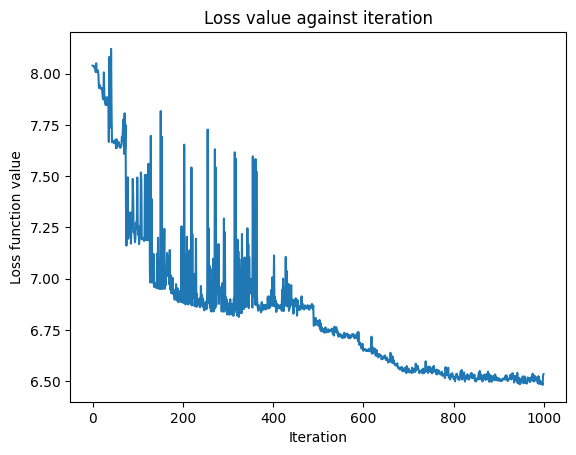

[ 0.45261049  1.50182635  0.14656401  1.4392829   1.33602967 -0.00834353
  0.73581536  0.43040413  0.35989445  1.50359903 -0.29985689  0.75041431
  1.40905542  1.52580472  0.82847081  0.50512443 -0.08675737  0.09309668
  2.1485555   1.41236466  0.31774525  1.40484161  1.70055221  0.34333768
  0.43142278  0.218288    1.1457478   1.26113714  1.86892662  0.4312388
  1.57833541  0.38598047  0.67495517  0.30102487  0.69025757  1.65357648
  0.22993529  0.16125897  0.25939968  0.11975455  0.03950343  0.22067792
  1.41291815  0.06083648  0.48971935 -0.5153979   0.92241828  1.19336055
  0.56515369  0.3583817  -0.3724046   1.64234752  0.89531528  0.75400489
  0.38462712  0.63822751  0.49810686 -0.05716188  0.51148907  0.45872292
  0.85248718  0.68564821  0.82652209  1.27171292  0.39315332  0.69942301
  0.16468317  0.85387282  0.47220526  1.63656493 -0.13566081  0.09421143
  0.25239408  1.37843165  2.10393307  0.71675639  0.31843705 -0.37035414
  0.62282864 -0.0125604   0.52653753  0.93739656  1.

In [30]:
# Call Training Function and Save as Result
result = fit(iter=1000, fresh_start=False)

In [31]:
savemodel = Model(TorchConnector(estimator, result[0].x))
print(next(model.parameters()).is_cuda)
torch.save(savemodel, "2Classes_Circuit2A_CCELoss(OneHot)")

True


In [32]:
evalmodel = torch.load("2Classes_Circuit2A_CCELoss(OneHot)", weights_only=False).to("cuda")
evalmodel.eval()
output0 = evalmodel(X)
output1 = evalmodel(X1)
print(f"Train Accuracy: {accuracy(output0, Y)}%")
print(f"Test Accuracy: {accuracy(output1, Y1)}%")

Train Accuracy: 76.5625%
Test Accuracy: 71.875%


In [33]:
def translate(array):
    arr = []
    for e in array:
        arr.append(torch.argmax(e))
    return arr
print(f"output 0: {translate(output0)}, \n Y:       {translate(Y)}, \n output 1: {translate(output1)}, \n Y1:       {translate(Y1)}")

output 0: [tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1,

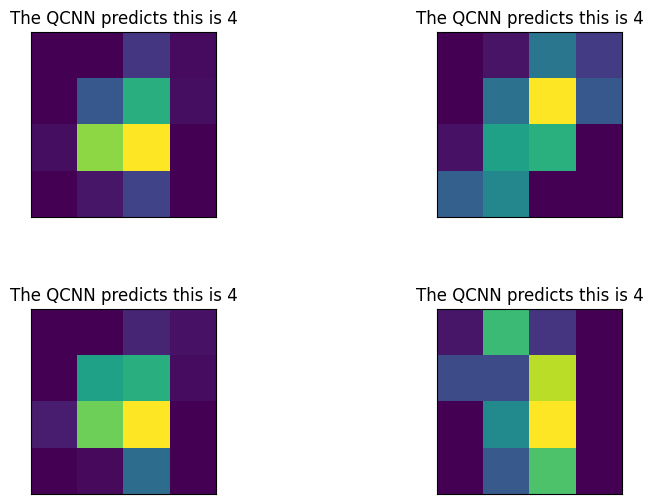

In [34]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(X.detach().cpu().numpy()[i].reshape(4, 4), aspect="equal")
    if torch.argmax(output1[i]) == 0:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is 3")
    if torch.argmax(output1[i]) == 1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is 4")
plt.subplots_adjust(wspace=0.1, hspace=0.5)

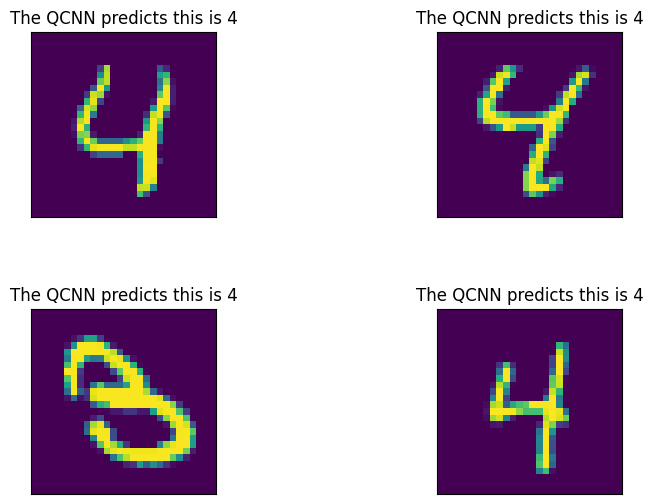

In [35]:
x_tesfig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(x_test[i].reshape(28, 28), aspect="equal")
    if torch.argmax(output1[i]) == 0:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is 3")
    if torch.argmax(output1[i]) == 1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is 4")
plt.subplots_adjust(wspace=0.1, hspace=0.5)

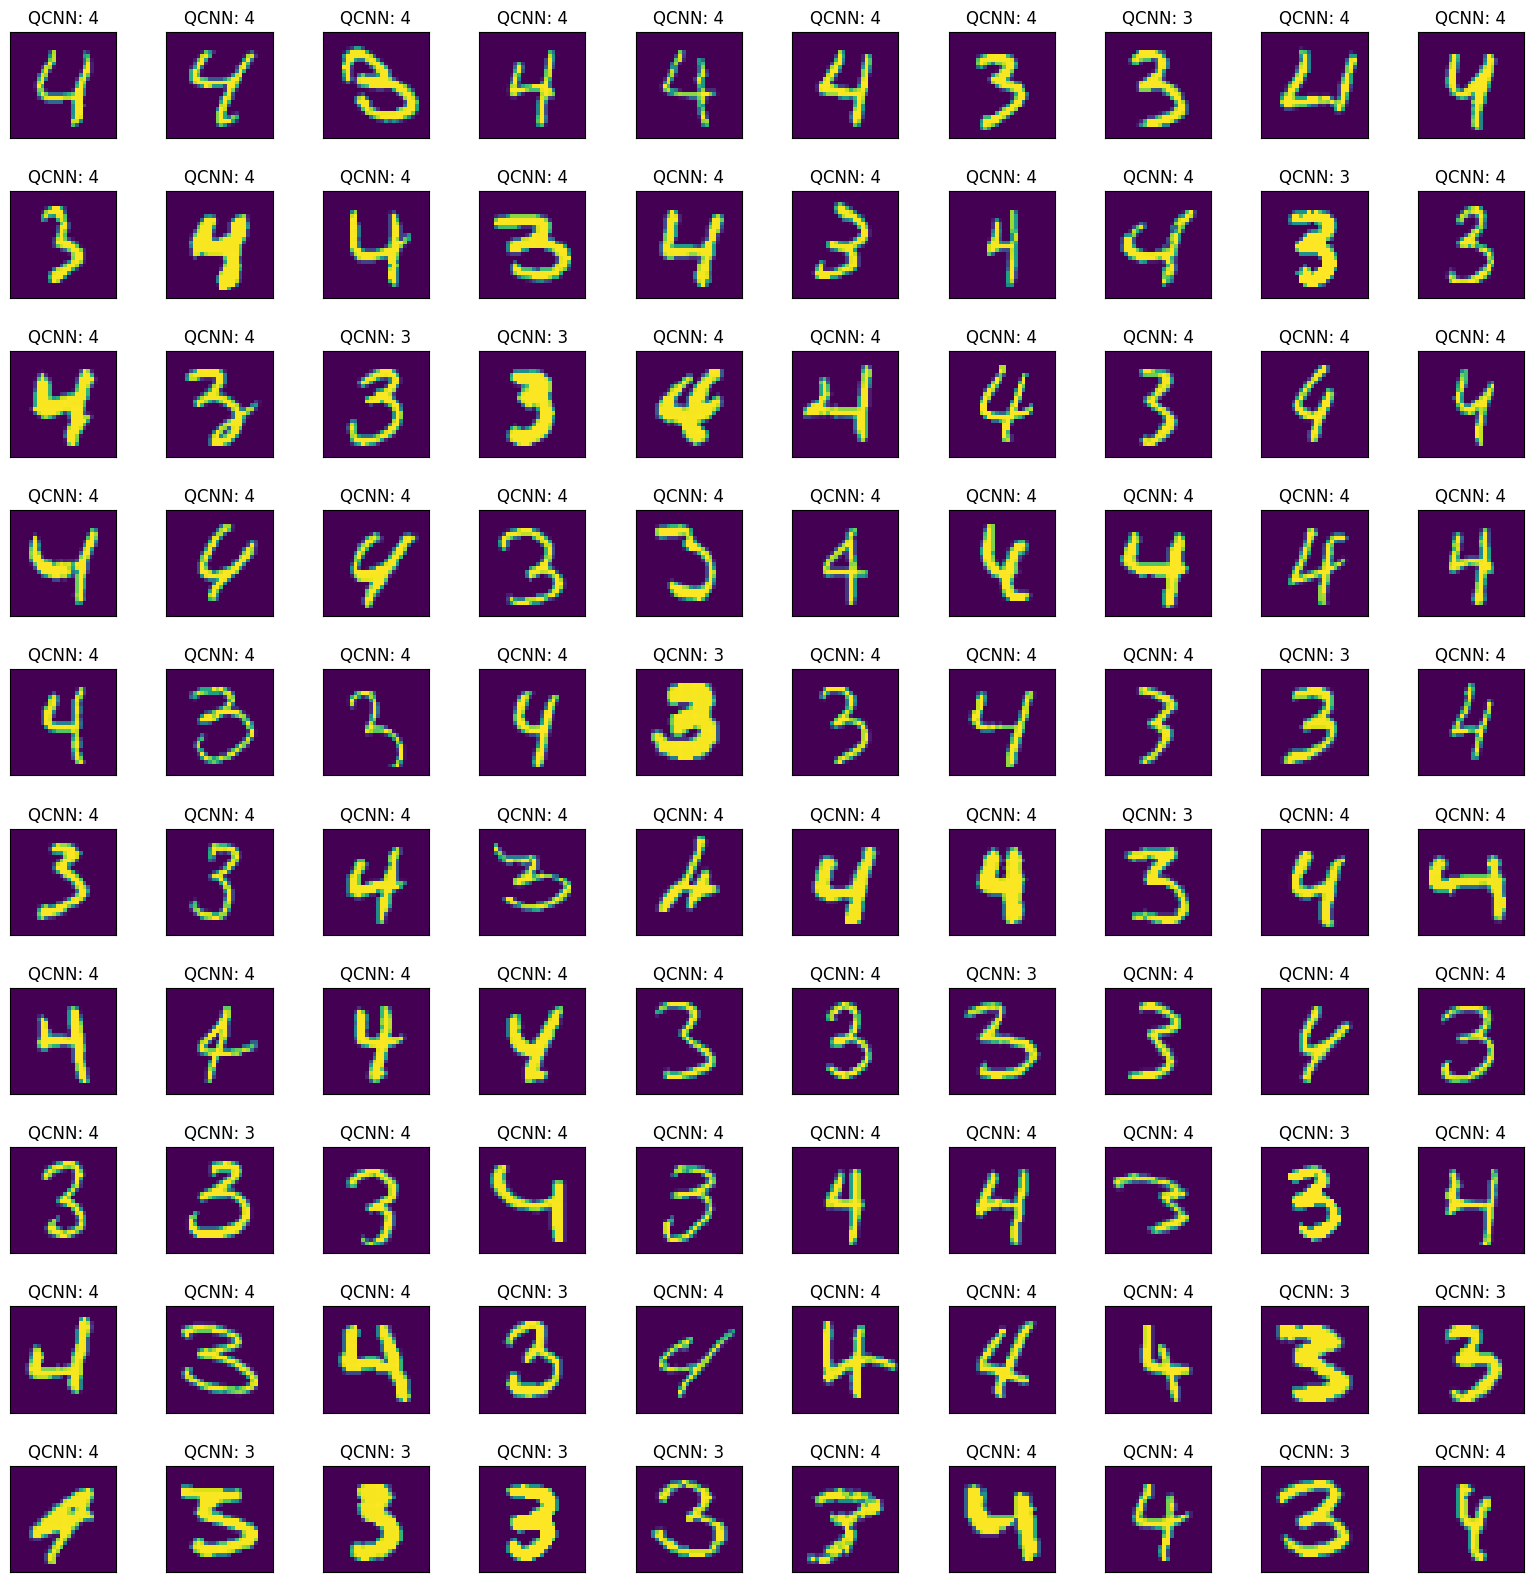

In [36]:
num_rows = 10
num_cols = 10
fig, ax = plt.subplots(num_rows, num_cols, figsize=(20, 20),
                       subplot_kw={"xticks": [], "yticks": []})

for i in range(num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    
    if i < len(x_test) and i < len(output1):
      ax[row, col].imshow(x_test[i].reshape(28, 28), aspect="equal")

      if torch.argmax(output1[i]) == 0:
          ax[row, col].set_title("QCNN: 3")
      elif torch.argmax(output1[i]) == 1:
          ax[row, col].set_title("QCNN: 4")
      else:
          ax[row, col].set_title("QCNN: Other")
    else:
        ax[row, col].axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.5)
plt.show()

In [37]:
print(result)

( message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 6.481138229370117
       x: [ 4.526e-01  1.502e+00 ... -2.002e-02 -3.595e-01]
    nfev: 1000
   maxcv: 0.0, ['Iteration: 1; Accuracy: 50.0%; Loss: 8.039141654968262', 'Iteration: 2; Accuracy: 50.0%; Loss: 8.039289474487305', 'Iteration: 3; Accuracy: 50.0%; Loss: 8.03763484954834', 'Iteration: 4; Accuracy: 50.0%; Loss: 8.03763484954834', 'Iteration: 5; Accuracy: 50.0%; Loss: 8.027514457702637', 'Iteration: 6; Accuracy: 49.21875%; Loss: 8.027229309082031', 'Iteration: 7; Accuracy: 49.21875%; Loss: 8.027229309082031', 'Iteration: 8; Accuracy: 50.0%; Loss: 8.008213996887207', 'Iteration: 9; Accuracy: 50.78125%; Loss: 8.050607681274414', 'Iteration: 10; Accuracy: 50.0%; Loss: 8.008213996887207', 'Iteration: 11; Accuracy: 53.90625%; Loss: 8.012428283691406', 'Iteration: 12; Accuracy: 54.6875%; Loss: 8.017462730407715', 'Iteration: 13; Accuracy: 50.0%; Loss: 8.008213996887207', 'Iteratio

In [38]:
result[1]

['Iteration: 1; Accuracy: 50.0%; Loss: 8.039141654968262',
 'Iteration: 2; Accuracy: 50.0%; Loss: 8.039289474487305',
 'Iteration: 3; Accuracy: 50.0%; Loss: 8.03763484954834',
 'Iteration: 4; Accuracy: 50.0%; Loss: 8.03763484954834',
 'Iteration: 5; Accuracy: 50.0%; Loss: 8.027514457702637',
 'Iteration: 6; Accuracy: 49.21875%; Loss: 8.027229309082031',
 'Iteration: 7; Accuracy: 49.21875%; Loss: 8.027229309082031',
 'Iteration: 8; Accuracy: 50.0%; Loss: 8.008213996887207',
 'Iteration: 9; Accuracy: 50.78125%; Loss: 8.050607681274414',
 'Iteration: 10; Accuracy: 50.0%; Loss: 8.008213996887207',
 'Iteration: 11; Accuracy: 53.90625%; Loss: 8.012428283691406',
 'Iteration: 12; Accuracy: 54.6875%; Loss: 8.017462730407715',
 'Iteration: 13; Accuracy: 50.0%; Loss: 8.008213996887207',
 'Iteration: 14; Accuracy: 52.34375%; Loss: 7.995648384094238',
 'Iteration: 15; Accuracy: 50.0%; Loss: 7.93049430847168',
 'Iteration: 16; Accuracy: 50.0%; Loss: 7.93049430847168',
 'Iteration: 17; Accuracy: 54.